# Kostrov summation
## From moment sensors to deformation, strain rate and velocity

In [1]:
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely as sp
import pyproj

with open('earthquakes.txt') as f:
    array = [[x for x in line.split()] for line in f]
cmt_data = np.array(array)

In [2]:
# specify the polygons
import geopandas as gpd
import matplotlib.pyplot as plt

# enabling reading kml files with geopandas
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

fp = "final_polygons.kml"
polys = gpd.read_file(fp, driver='KML')
polygons = polys[['geometry']]

def coord_lister(geom):
    coords = list(geom.exterior.coords)
    return (coords)

coordinates = polygons.geometry.apply(coord_lister)

In [5]:
import warnings
warnings.filterwarnings("ignore") # filter warnings for changing coordinate systems

def kostrov_summation(eq_zone):
    # kostrov summation
    mrr = 0
    mtt = 0
    mpp = 0
    mrt = 0
    mrp = 0
    mtp = 0
    scalar_moment = 0

    # sum up all tensors
    for i in range(len(eq_zone)):
        iexp = int(eq_zone[i][9])
        mrr += float(eq_zone[i][3])*10**iexp
        mtt += float(eq_zone[i][4])*10**iexp
        mpp += float(eq_zone[i][5])*10**iexp
        mrt += float(eq_zone[i][6])*10**iexp
        mrp += float(eq_zone[i][7])*10**iexp
        mtp += float(eq_zone[i][8])*10**iexp
        
        scalar_moment += float(eq_zone[i][14])
        
    # convert from dyn cm to Nm   
    mrr = mrr/10**7
    mtt = mtt/10**7
    mpp = mpp/10**7
    mrt = mrt/10**7
    mrp = mrp/10**7
    mtp = mtp/10**7
    
     # convert to float notation 
    mrr = mrr/10**16
    mtt = mtt/10**16
    mpp = mpp/10**16
    mrt = mrt/10**16
    mrp = mrp/10**16
    mtp = mtp/10**16
    
    return mrr, mtt, mpp, mrt, mrp, mtp


# store tensors
tensors = []
coords = []
frequency = []
scalar_moments = []
box_depth = []
max_box_depth = []
areas = []

for i in coordinates:
    poly = Polygon(i)
    coord_poly = list(poly.centroid.coords)
    
    # keep track of number of earthquakes within polygon
    eq_zone = []
    eq_zone_depth = []
    freq_eqs = []
    scalar_moment1 = 0
    scalar_moment2 = 0
    number_eqs1 = 0
    eq_depths1 = 0
    max_depth1 = []
    number_eqs2 = 0
    eq_depths2 = 0
    max_depth2 = []
    for line in range(len(cmt_data)):
        x = (float(cmt_data[line][0]))
        y = (float(cmt_data[line][1]))
        point = Point(x,y)
        
        # add earthquakes to catalogue if it is within the polygon
        if (poly.contains(point)) == True:
            depth = (float(cmt_data[line][2]))
            eq_zone.append(cmt_data[line])
            eq_depths1 += depth
            max_depth1.append(depth)
            number_eqs1 += 1
            scalar_moment1 += float(cmt_data[line][14])
            
            # collect data for frequency magnitude plot
            freq_eqs.append(float(cmt_data[line][13]))
            
    if number_eqs1 == 0:
        mean_depth1 = 0
    else: 
        mean_depth1 = eq_depths1 / number_eqs1
        max_depths1 = max(max_depth1)
        max_box_depth.append(max_depths1 * 1000) #from kilometres to m
    box_depth.append(max_depths1*1000) #from kilometres to m
    scalar_moments.append(scalar_moment1)
    mrr,mtt,mpp,mrt,mrp,mtp = kostrov_summation(eq_zone)

    tensors.append([*coord_poly[0],mean_depth1,mrr,mtt,mpp,
                    mrt,mrp,mtp,16,'X', 'Y', '200808180916A'])
    
    # Calculate the areas of the polygon  
    s = shape(poly)
    # from spherical to cartesian coordinates
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))
    s_new = transform(proj, s)
    poly_area = transform(proj, s).area
    areas.append(poly_area)
    
    frequency.append([*coord_depth,*freq_eqs])
    

In [6]:
coord_depth = np.subtract(coord_poly[0], (0.5, 0.5))

In [7]:
tensor = np.array(tensors)
#tensor = tensor.astype(np.float)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('polygonsnodepth.txt', tensor, delimiter = ' ', fmt="%s")

In [131]:
df = pd.read_excel (r'velo_info.xlsx', columns= ['coordinates', 'eigenvalues'])
velo_info = df.to_numpy()

## Freq-mag plot

1
3
18
19
22


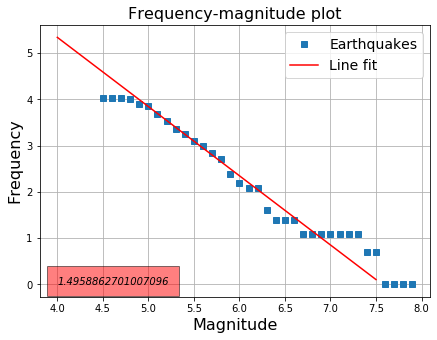

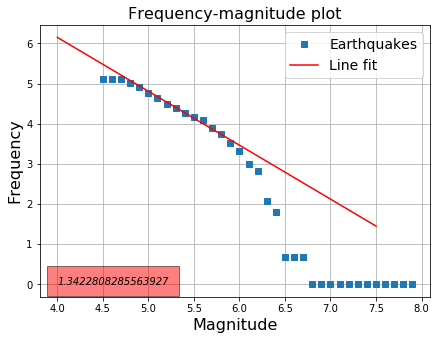

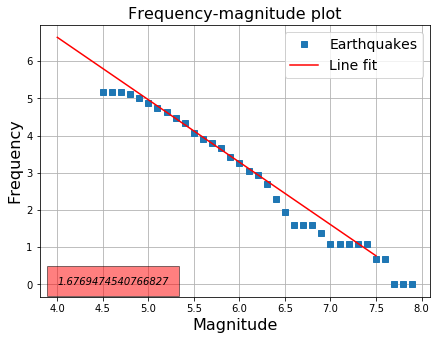

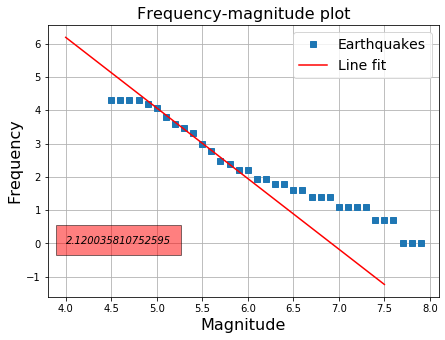

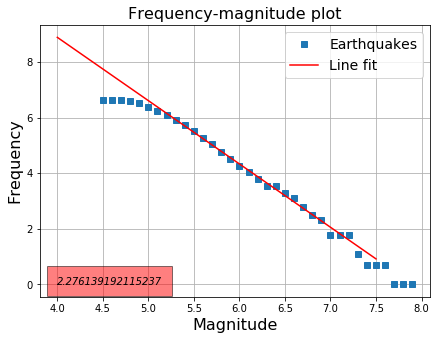

In [9]:
b_values = []
bs = []
b_plot =[]
freq = frequency
box_count = 0
for line in freq:
    box_count += 1
    i = 4.5
    x = [0.5,1,1.5,2,2.5,3,3.5,4]
    while i < 8:
        x.append(round(i,2))
        i += 0.1
    x.append(8.5)
    x.append(9)
    x.append(9.5)
    y = [0] * len(x)
    coord_lon = line.pop(0)
    coord_lat = line.pop(1)
    for i in line:
        if (i > 0.5):
            # all eqs above 0.5
            y [0] += 1
        if i > 1:
            # between 0.5 and 1
            y [1] += 1
        if i > 1.5:
            y [2] += 1
        if i > 2:
            y [3] += 1
        if i > 2.5:
            y [4] += 1
        if i > 3:
            y [5] += 1
        if i > 3.5:
            y [6] += 1
        if i > 4:
            y [7] += 1
        if i > 4.5:
            y [8] += 1
        if i > 4.6:
            y [9] += 1
        if i > 4.7:
            y [10] += 1
        if i > 4.8:
            y [11] += 1
        if i > 4.9:
            y [12] += 1
        if i > 5:
            y [13] += 1
        if i > 5.1:
            y [14] += 1
        if i > 5.2:
            y [15] += 1
        if i > 5.3:
            y [16] += 1
        if i > 5.4:
            y [17] += 1
        if i > 5.5:
            y [18] += 1
        if i > 5.6:
            y [19] += 1
        if i > 5.7:
            y [20] += 1
        if i > 5.8:
            y [21] += 1
        if i > 5.9:
            y [22] += 1
        if i > 6:
            y [23] += 1
        if i > 6.1:
            y [24] += 1
        if i > 6.2:
            y [25] += 1
        if i > 6.3:
            y [26] += 1
        if i > 6.4:
            y [27] += 1
        if i > 6.5:
            y [28] += 1
        if i > 6.6:
            y [29] += 1
        if i > 6.7:
            y [30] += 1
        if i > 6.8:
            y [31] += 1
        if i > 6.9:
            y [32] += 1
        if i > 7:
            y [33] += 1
        if i > 7.1:
            y [34] += 1
        if i > 7.2:
            y [35] += 1
        if i > 7.3:
            y [36] += 1
        if i > 7.4:
            y [37] += 1
        if i > 7.5:
            y [38] += 1
        if i > 7.6:
            y [39] += 1
        if i > 7.7:
            y [40] += 1
        if i > 7.8:
            y [41] += 1
        if i > 7.9:
            y [42] += 1
        if i > 8:
            y [43] += 1 
        if i > 8.5:
            y [44] += 1
        if i > 9:
            y [45] += 1
        if i > 9.5:
            y [46] += 1 

    """
    # Boolean mask
    mask = y != 0
    y = y[mask]
    x = x[mask"
"""
    logy = [np.log(z) for z in y if z != 0]
    #logy = np.log10(y)
    # straight-line fit with numpy polyfit
    poly_coeffs = np.polyfit(x[15:23], logy[15:23], 1)
    x_line = np.linspace(4, 7.5, 100)
    p1 = np.poly1d(poly_coeffs)
    b = poly_coeffs[0] * -1
    # only for top polygons plot the b-value
    b_plot.append(b)
    b_values.append([coord_lon, coord_lat, b])
    if y[1] > 50:
        if abs(b) == 0:
            bs.append(0.1)
        else:
            bs.append(b)
            print(box_count)
            # loglog plot
            fig = plt.figure(figsize=(7,5))
            ax1 = plt.subplot(111)
            ax1.plot(x[8:43], logy[8:43], 's', label='Earthquakes')
            ax1.plot(x_line, p1(x_line), 'r', label = 'Line fit')
            ax1.set_title('Frequency-magnitude plot', fontsize=16)
            ax1.grid(True)
            ax1.text(4, 0, b, style='italic',
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
            ax1.set_xlabel('Magnitude', fontsize=16)
            ax1.set_ylabel('Frequency', fontsize=16)
            ax1.legend(loc='best', fontsize=14)
    else: bs.append(np.nan)
    

Text(0.5, 1, 'Heatmap of the b-value for regions in the caribbean plate')

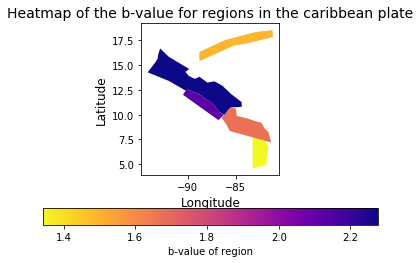

In [159]:
# b-value calculated for entire polygon
p_and_b = gpd.GeoDataFrame.copy(polygons)
p_and_b ['b-value'] = bs

fig, ax = plt.subplots(1, 1)
p_and_b.plot(column='b-value', cmap='plasma_r', ax=ax, legend= True, legend_kwds={'label': "b-value of region",
                        'orientation': "horizontal"})
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Heatmap of the b-value for regions in the caribbean plate', fontsize=14)

## Velocity

In [130]:
print(max_box_depth)

[40000.0, 18000.0, 42000.0, 20000.0, 33000.0, 23000.0, 52000.0, 14000.0, 116000.0, 173000.0, 65000.0, 160000.0, 156000.0, 22000.0, 35000.0, 62000.0, 34000.0, 66000.0, 34000.0, 113000.0, 90000.0, 251000.0, 273000.0, 160000.0, 40000.0, 107000.0, 90000.0, 39000.0, 108000.0]


In [132]:
# for velocity, use sum of all the moment tensors. 
# but use with and length of fault too
# velocity = 1/(mu*L*W*t)* sum(m_0)
        
# Length of faults in boxes from a csv file
velocities = []
t = (2021-1976 + 10/12) *365.25*24*3600
mu =  3.3*10**10 
for i in range(len(scalar_moments)):
    m0 = float(scalar_moments[i])/(10**7)
    L = float(velo_info[i][20]) #in m
    w = max_box_depth[i] 
    dip_fault = float(velo_info[i][19])
    dip_rad = np.deg2rad(dip_fault)
    # sin(dip) = depth/W
    W = w/np.sin(float(dip_rad))
    v = 1/(L*mu*W*t)*m0
    #convert to mm/yr
    vyr = v * 3.1556926 * 10 ** 10
    velocities.append([(velo_info[i][0]), velo_info[i][1], vyr])
print(velocities)

[[-85.09052600777474, 17.227151647225426, 7.737063533939866], [-86.759227093664, 15.691218641096366, 0.10344874290365624], [-82.55561451789657, 6.16605363315168, 6.985779444908452], [-81.92155006231083, 12.797393501136108, 0.32382323685131126], [-77.67016478244659, 19.577097310133997, 10.48969101763696], [-72.74994968487644, 14.716395937843616, 0.03528906769397978], [-71.39684145440228, 19.911868773551763, 0.058204624271309735], [-72.82107350541658, 18.48221332924139, 9.668909661704488], [-66.94969911212415, 18.23183262090195, 0.20152327854165486], [-62.16092637903297, 16.327057534641476, 0.8213874263123568], [-59.60781085791053, 14.652518442915287, 0.5672049574604896], [-62.85911931879893, 10.52332485799935, 1.0651147861980828], [-60.060475177437105, 10.802684775900195, 0.3715999770482187], [-80.3683614827235, 7.406381450333737, 0.22696001388224912], [-78.0150811655141, 6.3099947775539365, 6.880415391503348], [-77.33989813871635, 8.641078294609779, 0.3610714292371101], [-76.5471829476

## Seismic coupling

In [133]:
# coupling = velocity/gps velocity
coupling = []
coup =[]
for i in range(len(velocities)):
    velocity = float(velocities[i][2])
    gps_velocity = float(velo_info[i][3])
    lon = (velo_info[i][0])
    lat = float(velo_info[i][1])
    seismic_coupling = abs(velocity) / gps_velocity
    coupling.append([lon, lat, seismic_coupling])
    coup.append(seismic_coupling)

In [134]:
# M_seis = c * M_tectonic https://academic.oup.com/gji/article/209/1/32/2893453
 #high c, many earthquakes
    # low c: aseismic deformation


Text(0.5, 1, 'Heatmap of the seismic coupling at the caribbean plate')

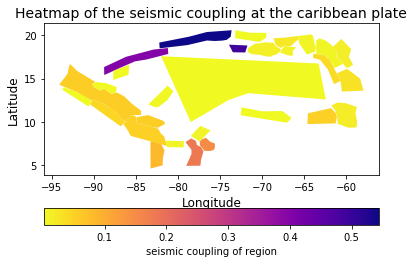

In [135]:
vandgps = gpd.GeoDataFrame.copy(polygons)

for i in range(len(coup)):
    if coup[i] > 2:
        coup[i] = 2

vandgps ['seismic_c'] = coup

fig, ax = plt.subplots(1, 1)
vandgps.plot(column='seismic_c', cmap='plasma_r', ax=ax, legend= True, legend_kwds={'label': "seismic coupling of region",
                        'orientation': "horizontal"})
plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('Heatmap of the seismic coupling at the caribbean plate', fontsize = 14)

## Strain rates

In [136]:
volumes = []
# calculate volume of all the boxes
for i in range(len(areas)):
    volume_box = float(areas[i]) * float(max_box_depth[i]) # max depth or seismogenic depth
    volumes.append(volume_box)

mu = 3.3*10**10
strain_tensors = []

i = 0

for i in range(len(velo_info)):
    e_t = float(velo_info[i][4])/(mu*volumes[1]*2)*10**16
    e_b = float(velo_info[i][5])/(mu*volumes[1]*2)*10**16
    e_p = float(velo_info[i][6])/(mu*volumes[1]*2)*10**16
    lon = float(velo_info[i][0])
    lat = float(velo_info[i][1])
    strain_tensors.append([lon, lat, e_t, e_b, e_p])
    i += 1    

# compute strain rate
strain_rates = []
t = (2021-1976 + 10/12)
for line in strain_tensors:
    et_t = float(line[2])/t
    et_b = float(line[3])/t
    et_p = float(line[4])/t
    strain_rates.append([float(line[0]), float(line[1]), et_t, et_b, et_p])

# string crosses from diagonalised summed moment tensors MTTK, gmt velo]

In [137]:
strain_crossesred = []
strain_crossesblue = []
strain_crosses = []
strain_b = []
t = (2021-1976 + 10/12) * 365.25 * 24 * 3600
for i in range(len(strain_rates)):
    lon_strain = strain_rates[i][0]
    lat_strain = strain_rates[i][1]
    I_strain = float(strain_rates[i][3])
    I_dip = np.deg2rad(float(velo_info[i][9]))
    I_hor_strain = I_strain * np.cos(float(I_dip))
    T_strain = float(strain_rates[i][2])
    T_dip = np.deg2rad(float(velo_info[i][11]))
    T_hor_strain = T_strain * np.cos(float(T_dip))
    P_strain = float(strain_rates[i][4])
    # horizontal strain = strain * P dip
    P_dip = np.deg2rad(float(velo_info[i][7]))
    P_hor_strain = P_strain * np.cos(float(P_dip))
    P_strike = float(velo_info[i][8])
    strain_crosses.append([lon_strain,lat_strain,T_hor_strain,P_hor_strain,P_strike])
    strain_crossesred.append([lon_strain,lat_strain,T_hor_strain,0,P_strike])
    strain_crossesblue.append([lon_strain,lat_strain,0,P_hor_strain,P_strike])
    strain_b.append([T_hor_strain,I_hor_strain,P_hor_strain])
        
strain_crossred = np.array(strain_crossesred)
strain_crossblue = np.array(strain_crossesblue)
strain_crosssave = np.array(strain_crosses)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('strain_crosses2D2.txt', strain_crosssave, delimiter = ' ', fmt="%s")
np.savetxt('strain_crossesred2D.txt', strain_crossred, delimiter = ' ', fmt="%s")
np.savetxt('strain_crossesblue2D.txt', strain_crossblue, delimiter = ' ', fmt="%s")

Text(0.5, 1, 'Heatmap of the deformation type for regions in the caribbean plate')

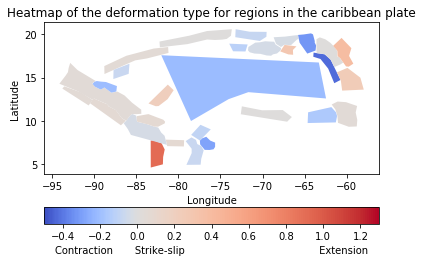

In [175]:
# style of deformation from my strain rates
import matplotlib.colors as mcolors
class MidPointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
# calculate style tensor
def defstyle(emax, emin):
    return (emax+emin)/max(abs(emax), abs(emin))

defstyles = []       
for j in strain_rates:
    emax = j[2]
    emin = j[4]
    defs = defstyle(emax,emin)
    defstyles.append(defs)

    # -1 is contraction, +1 is extension, 0 is strike-slip
poly_deftype = gpd.GeoDataFrame.copy(polygons)
poly_deftype['def_type'] = defstyles

fig, ax = plt.subplots(1, 1)

norm=MidPointNormalize(-0.5, 1.3, 0)
poly_deftype.plot(column='def_type', cmap='coolwarm', norm=norm, ax=ax, legend= True, legend_kwds={'label': "Contraction       Strike-slip                                           Extension",
                        'orientation': "horizontal"})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of the deformation type for regions in the caribbean plate')

## plot velocities in GMT

In [117]:
# in GMT, format is lon, lat, Evel (mm/yr), Nvel (mm/yr)
plot_psvelo = []
for i in range(len(velocities)):
    lon = velocities[i][0]
    lat = velocities[i][1]
    strike_fault = np.deg2rad(float(velo_info[i][22]))
    velocity = velocities[i][2]
    Evel = velocity * np.sin(strike_fault)
    Nvel = velocity * np.cos(strike_fault)
    plot_psvelo.append([lon,lat,Evel,Nvel,0,0,0])

In [118]:
plt_psvelo = np.array(plot_psvelo)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('gmt_psvelo3.txt', plt_psvelo, delimiter = ' ', fmt="%s")

Text(0.5, 1, 'Heatmap of the deformation type for regions in the caribbean plate')

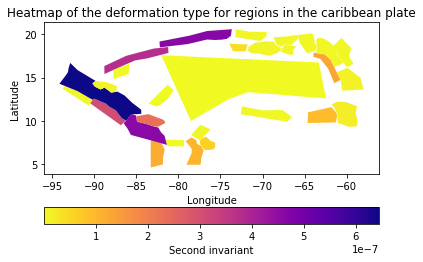

In [127]:
#for i in strain_crosssave:
#    print(i[2],i[3])
       
absolute_strain2D = []
for i in range(len(strain_crosssave)):
    #e = np.sqrt(float(strain_b[i][0])**2+float(strain_b[i][1])**2+float(strain_b[i][2])**2)
    e = np.sqrt(float(strain_crosssave[i][2])**2+float(strain_crosssave[i][3])**2)
    absolute_strain2D.append(e)    
    
poly_deftype = gpd.GeoDataFrame.copy(polygons)
poly_deftype['second invariant'] = absolute_strain2D

fig, ax = plt.subplots(1, 1)
poly_deftype.plot(column='second invariant', cmap='plasma_r', ax=ax, legend= True, legend_kwds={'label': "Second invariant",       
                        'orientation': "horizontal"})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of the deformation type for regions in the caribbean plate')    

In [128]:
#print(velocities)

for i in range(len(velo_info)):
    print("box",i+1)
    print(velo_info[i][3])
    print(velocities[i][2])


box 1
19.335162269
7.737063533939866
box 2
73.18951427
0.10344874290365624
box 3
82.43218359999999
6.976535809405707
box 4
80.09
0.32382323685131126
box 5
19.2839
10.48969101763696
box 6
20.086856
0.03528906769397978
box 7
19.49203
0.058204624271309735
box 8
19.626839999999998
9.985311157905539
box 9
19.87511
0.20152327854165486
box 10
20.246570000000002
0.8213874263123568
box 11
19.200377
0.5672049574604896
box 12
20.321048
1.0651147861980828
box 13
20.443779
0.3715999770482187
box 14
36.6383679
0.22696001388224912
box 15
37.5785
6.880415391503348
box 16
36.639421999999996
0.3610714292371101
box 17
37.413000000000004
5.65547023620085
box 18
79.5092548
4.245808819789813
box 19
73.35424868
3.346839133898356
box 20
79.75785
4.651287905078021
box 21
68.0567
0.23048944554626463
box 22
71.05014
4.069498864014952
box 23
71.57685
0.11890466167333222
box 24
19.761976
0.2621954313803417
box 25
19.72875
0.4868273433446552
box 26
19.855207999999998
0.1331505751880944
box 27
20.0552238
0.123686492